# PyTorch, CNN 개/고양이 분류
```planintext
dataset/train/
├── cat/    ← class 0
│   ├── cat.0.jpg
│   └── ...
└── dog/    ← class 1
    ├── dog.0.jpg
    └── ...
dataset/valid/
├── cat/    ← class 0
│   ├── cat.0.jpg
│   └── ...
└── dog/    ← class 1
    ├── dog.0.jpg
    └── ...
```

## Batch(mini-batch) 학습이란?
* 머신러닝에서 모델에 학습 데이터를 전달할 때 샘플을 한개씩 전달하는 것은 순차처리하는 것이므로 많은 데이터를 학습할 때는 많은 시간이 소요된다
* Tensor를 사용하면 PyTorch, Tensorflow같은 신경망 프레임워크에서 병열처리를 지원하므로 한꺼번에 다수개의 샘플을 모델에게 전달할 수 있다
* 개발자는 신경망을 설계할 때 1개의 샘플을 대상으로 모델을 설정하고 모델에 데이터를 전달할 때는 반드시 Batch 단위로 전달해야 한다.
* 즉, 한개의 샘플을 전달하더라도 Batch 차원을 고려하여 한 차원 높여서 전달해야 한다
* 신경망에 데이터를 전달할 때는 Batch를 전달해야 하며 신경망은 반드시 Batch를 리턴한다
### Batch처리의 장점
* GPU, TPU는 병렬연산에 최적화되어 하드웨어 자원을 효율적으로 사용할 수 있음
* 한개의 샘플만 사용하여 가중치를 업데이트하면 미분값의 분산이 크고 노이즈가 많음
* Batch처리를 하면 여러 샘플의 평균 미분값이 사용되므로 안정적이고 빠르고 노이즈에 취약하지 않음
* 딥러닝 프레임워크들은 내부에서 벡터 연산을 사용하여 Batch연산에 최적화되어 있음
* Batch Normalization 등 Batch단위를 기반으로 하는 정규화 기법들이 쉽게 적용됨
### Batch처리의 단점
* 더 많은 GPU 메모리 필요
* 고해상도 이미지나 대형 모델에서는 작은 배치로 제한될 수 있다
* 큰 배치는 미분 평균값을 잘 반영하지만 지역 최소(local minima)에 갇힐 가능성이 있다
* 작은 배치는 노이즈가 많아도 더 다양한 지역을 탐색하므로 더 일반화가 잘되는 경우가 있다
* 실시간 학습에는 부적합(실시간 데이터는 On-Line Learning이 더 적합


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 1. 하이퍼파라미터 및 설정
BATCH_SIZE = 4
EPOCHS = 200
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE=", DEVICE)

# 2. 데이터 전처리
# 이미지를 전처리(Preprocessing) 하기 위한 연속된 변환 작업(transform pipeline) 을 정의
transform = transforms.Compose([
    transforms.Resize((128, 128)),      # 이미지를 고정 크기로 설정
    transforms.ToTensor(),              # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize([0.5], [0.5])  # 빠르고 안정적인 학습을 위한 정규화(0~1 -> -1~1), (x-0.5)/0.5
])
data_path = "/content/drive/MyDrive/Python_AI/CNN/dataset"
train_dataset = datasets.ImageFolder(root=data_path+'/train', transform=transform)
valid_dataset = datasets.ImageFolder(root=data_path+'/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  # 모델이 순서에 영향을 받지 않도록 매 epoch마다 무작위로 섞는다
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False) # 데이터 순서 고정

class_names = train_dataset.classes  # ['cat', 'dog']

# 3. 모델 정의
# 신경망을 정의할 때는 Batch 크기를 고려하지 않지만 Tensor 연산은 배치단위 병렬처리가 기본임
# 신경망에 데이터를 전달할 때는 Batch 단위로 전달해야 하며 신경망 출력측에서도 배치단위로 출력된다
# 개발자는 하나의 샘플을 기준으로 신경망 구조만 정의하면 되며,
# 여러 샘플을 병렬로 처리하는 역할은 프레임워크(Pytorch, TensorFlow)가 자동으로 수행한다.
# 모델과 모델에 전달할 데이터는 모두 동일한 장치(GPU)로 이동해야 한다
# PyTorch는 CPU Tensor와 GPU Tensor 간 연산을 허용하지 않음
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # nn.Conv2d(3채널(RGB), 필터수, 필터크기, stride=1, padding=0)
            nn.Conv2d(3, 16, 3, padding=1),  # 128x128x3 -> 128x128x16, padding=1은 1픽셀 추가하여 출력크기 유지
            nn.BatchNorm2d(16),     # 안정적인 학습을 위해
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> 64x64x16, 이미지 크기를 1/2로 축소(국소적 특징 요약)
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> 32x32x32
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),  # 입력은 CNN에서 전달된 크기, 출력은 보통 64, 128, 256, 512 등
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)   # 최종 출력이 1이면 Sigmoid연결, 2이면 Softmax연결
            # BCEWithLogitsLoss() (또는 BCELoss + Sigmoid),	CrossEntropyLoss() (Softmax 포함)
        )

    def forward(self, x):   # 순전파(forward) 정의
        return self.fc(self.conv(x))

model = SimpleCNN().to(DEVICE)   # 모델과 데이터는 GPU로 이동하고 그 참조를 구한다
criterion = nn.CrossEntropyLoss()  # Softmax 포함
optimizer = optim.Adam(model.parameters(), lr=LR)

# 4. 학습 및 시각화용 리스트
train_acc_list, val_acc_list = [], []

for epoch in range(EPOCHS):
    model.train()
    correct, total, loss_total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)   # 학습용 데이터를 GPU로 이동 및 참조 리턴
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        correct += (outputs.argmax(1) == y).sum().item()  # (r,c)
        total += y.size(0)
    train_acc = correct / total
    train_acc_list.append(train_acc)

    # 검증
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in valid_loader:
            # Tensor 데이터를 지정된 디바이스(CPU 또는 GPU)로 이동시키고, 새 참조 리턴
            x, y = x.to(DEVICE), y.to(DEVICE)   # 검증용 데이터도 GPU로 이동
            outputs = model(x)
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
    val_acc = correct / total
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1} | Loss: {loss_total:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# 5. 학습 시각화
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# 6. 모델 저장
torch.save(model.state_dict(), "cat_dog_cnn.pth")

# 7. 모델 로드 (예시)
model.load_state_dict(torch.load("cat_dog_cnn.pth", map_location=DEVICE))  # 모델을 로드하여 GPU 로 이동
model.eval()

# 8. 실제 이미지 예측 함수
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")    # 1채널이거나 RGBA, BGR이라면 RGB로 변환
    # 모델에 데이터를 전달할 때는 학습할 때 사용했던 Batch 크기를 지킬 필요는 없으나 아래처럼 Batch로 포장은 해야 한다
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)    # 맨 앞 차원에 1추가 예, (3,128,128) -> (1,3,128,128)
    output = model(image_tensor)
    pred = output.argmax(dim=1).item()   # [B, number of classes] 차원에서 2번째 차원인 classes 중에서 가장 큰 값의 인덱스 리턴
    plt.imshow(np.array(image))
    plt.title(f"Prediction: {class_names[pred]}")
    plt.axis('off')
    plt.show()

# 9. 예측 실행 예시
predict_image(data_path+'/val/cat/cat1.jpg')  # 실제 파일 경로 지정

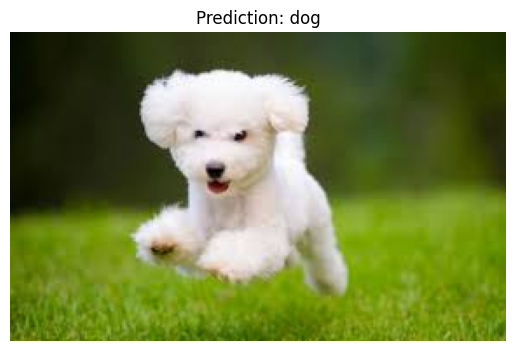

In [ ]:
predict_image(data_path+'/val/dog/dog1.jpg')  # 실제 파일 경로 지정

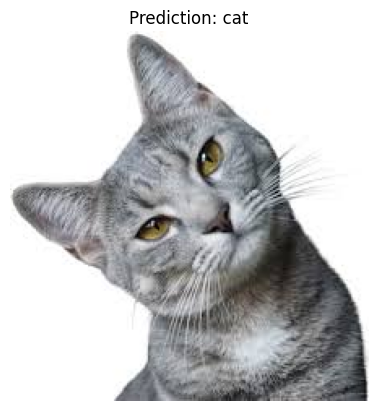

In [ ]:
predict_image(data_path+'/val/cat/cat1.jpg')  # 실제 파일 경로 지정

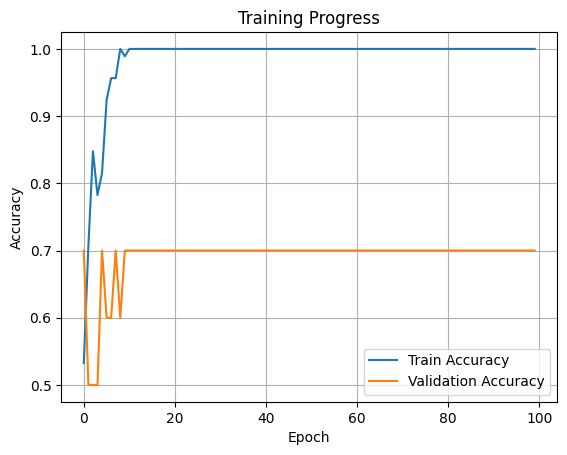

In [ ]:
# 5. 학습 시각화
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()